adapted from https://www.kaggle.com/nageshsingh/generate-realistic-human-face-using-gan

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from matplotlib import pyplot as plt

import tensorflow as tf

import os

from tqdm import tqdm
from PIL import Image as Img
from tensorflow.keras import Input
from tensorflow.keras.layers import Dense, Reshape, LeakyReLU, Conv2D, Conv2DTranspose, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop

In [2]:
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [3]:
PIC_DIR = f'../bundestagportraits_centercrop/'

IMAGES_COUNT = 1684
WIDTH = 128
HEIGHT= 128

images = []
for pic_file in tqdm(os.listdir(PIC_DIR)[:IMAGES_COUNT]):
    pic = Img.open(PIC_DIR + pic_file).convert("RGB") # "LA"
    pic.thumbnail((WIDTH, HEIGHT), Img.ANTIALIAS)
    images.append(np.uint8(pic))

100%|██████████| 1684/1684 [00:00<00:00, 1762.93it/s]


In [4]:
images = np.array(images) / 255
print(images.shape)

np.random.shuffle(images)

(1684, 128, 128, 3)


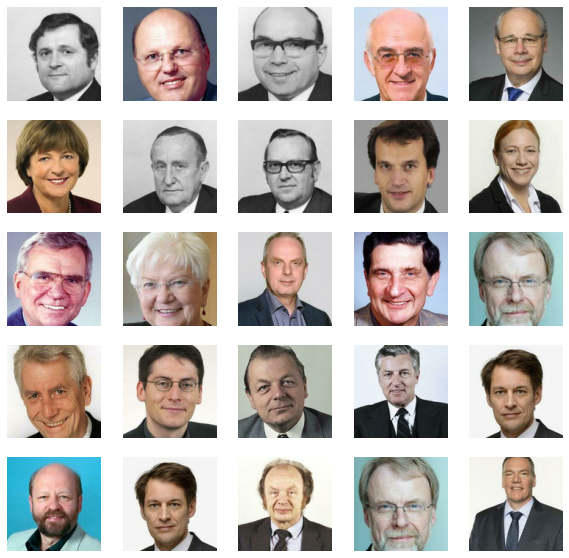

In [5]:
#Display random 25 images
plt.figure(1, figsize=(10, 10))
for i in range(25):
    ir = np.random.randint(IMAGES_COUNT)
    plt.subplot(5, 5, i+1)
    plt.imshow(images[ir])
    plt.axis('off')
plt.show()

In [6]:
LATENT_DIM = 32
CHANNELS = 3

def create_generator():
    gen_input = Input(shape=(LATENT_DIM, ))

    x = Dense(128 * 16 * 16)(gen_input)
    x = LeakyReLU()(x)
    x = Reshape((16, 16, 128))(x)

    x = Conv2D(256, 5, padding='same')(x)
    x = LeakyReLU()(x)

    x = Conv2DTranspose(256, 4, strides=2, padding='same')(x)
    x = LeakyReLU()(x)

    x = Conv2DTranspose(256, 4, strides=2, padding='same')(x)
    x = LeakyReLU()(x)

    x = Conv2DTranspose(256, 4, strides=2, padding='same')(x)
    x = LeakyReLU()(x)

    x = Conv2D(512, 5, padding='same')(x)
    x = LeakyReLU()(x)
    x = Conv2D(512, 5, padding='same')(x)
    x = LeakyReLU()(x)
    x = Conv2D(CHANNELS, 7, activation='tanh', padding='same')(x)

    generator = Model(gen_input, x)
    return generator

In [7]:
def create_discriminator():
    disc_input = Input(shape=(HEIGHT, WIDTH, CHANNELS))

    x = Conv2D(256, 3)(disc_input)
    x = LeakyReLU()(x)

    x = Conv2D(256, 4, strides=2)(x)
    x = LeakyReLU()(x)

    x = Conv2D(256, 4, strides=2)(x)
    x = LeakyReLU()(x)

    x = Conv2D(256, 4, strides=2)(x)
    x = LeakyReLU()(x)

    x = Conv2D(256, 4, strides=2)(x)
    x = LeakyReLU()(x)

    x = Flatten()(x)
    x = Dropout(0.4)(x)

    x = Dense(1, activation='sigmoid')(x)
    discriminator = Model(disc_input, x)

    optimizer = RMSprop(
        lr=.0001,
        clipvalue=1.0,
        decay=1e-8
    )

    discriminator.compile(
        optimizer=optimizer,
        loss='binary_crossentropy'
    )

    return discriminator

In [8]:
generator = create_generator()
generator.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32)]              0         
_________________________________________________________________
dense (Dense)                (None, 32768)             1081344   
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 32768)             0         
_________________________________________________________________
reshape (Reshape)            (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 16, 16, 256)       819456    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 16, 16, 256)       0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 32, 32, 256)       104883

In [9]:
discriminator = create_discriminator()
discriminator.trainable = False
discriminator.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 126, 126, 256)     7168      
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 126, 126, 256)     0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 62, 62, 256)       1048832   
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 62, 62, 256)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 30, 30, 256)       1048832   
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 30, 30, 256)       0   

In [10]:
gan_input = Input(shape=(LATENT_DIM, ))
gan_output = discriminator(generator(gan_input))
gan = Model(gan_input, gan_output)

In [11]:
optimizer = RMSprop(lr=.0001, clipvalue=1.0, decay=1e-8)
gan.compile(optimizer=optimizer, loss='binary_crossentropy')

In [12]:
gan.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 32)]              0         
_________________________________________________________________
model (Functional)           (None, 128, 128, 3)       14953987  
_________________________________________________________________
model_1 (Functional)         (None, 1)                 4211713   
Total params: 19,165,700
Trainable params: 14,953,987
Non-trainable params: 4,211,713
_________________________________________________________________


In [13]:
import time
iters = 10000
batch_size = 8

RES_DIR = 'res2'
FILE_PATH = '%s/generated_%d.png'
if not os.path.isdir(RES_DIR):
    os.mkdir(RES_DIR)

CONTROL_SIZE_SQRT = 6
control_vectors = np.random.normal(size=(CONTROL_SIZE_SQRT**2, LATENT_DIM)) / 2

start = 0
d_losses = []
a_losses = []
images_saved = 0
for step in range(iters):
    start_time = time.time()
    latent_vectors = np.random.normal(size=(batch_size, LATENT_DIM))
    generated = generator.predict(latent_vectors)

    real = images[start:start + batch_size]
    combined_images = np.concatenate([generated, real])

    labels = np.concatenate([np.ones((batch_size, 1)), np.zeros((batch_size, 1))])
    labels += .05 * np.random.random(labels.shape)

    d_loss = discriminator.train_on_batch(combined_images, labels)
    d_losses.append(d_loss)

    latent_vectors = np.random.normal(size=(batch_size, LATENT_DIM))
    misleading_targets = np.zeros((batch_size, 1))

    a_loss = gan.train_on_batch(latent_vectors, misleading_targets)
    a_losses.append(a_loss)

    start += batch_size
    if start > images.shape[0] - batch_size:
        start = 0
        np.random.shuffle(images)

    if step % 50 == 49:
        gan.save_weights('gan.h5')

        print('%d/%d: d_loss: %.4f,  a_loss: %.4f.  (%.1f sec)' % (step + 1, iters, d_loss, a_loss, time.time() - start_time))

        control_image = np.zeros((WIDTH * CONTROL_SIZE_SQRT, HEIGHT * CONTROL_SIZE_SQRT, CHANNELS))
        control_generated = generator.predict(control_vectors)
        
        for i in range(CONTROL_SIZE_SQRT ** 2):
            x_off = i % CONTROL_SIZE_SQRT
            y_off = i // CONTROL_SIZE_SQRT
            control_image[x_off * WIDTH:(x_off + 1) * WIDTH, y_off * HEIGHT:(y_off + 1) * HEIGHT, :] = control_generated[i, :, :, :]
        im = Img.fromarray(np.uint8(control_image * 255))#.save(StringIO(), 'jpeg')
        im.save(FILE_PATH % (RES_DIR, images_saved))
        images_saved += 1

50/10000: d_loss: 0.5324,  a_loss: 0.6857.  (1.2 sec)
100/10000: d_loss: 0.6932,  a_loss: 0.7447.  (1.2 sec)
150/10000: d_loss: 0.6907,  a_loss: 0.6992.  (1.3 sec)
200/10000: d_loss: 0.7154,  a_loss: 0.8189.  (1.2 sec)
250/10000: d_loss: 0.7224,  a_loss: 0.7828.  (1.3 sec)
300/10000: d_loss: 0.6752,  a_loss: 0.7329.  (1.3 sec)
350/10000: d_loss: 0.7264,  a_loss: 1.4177.  (1.2 sec)
400/10000: d_loss: 0.6822,  a_loss: 0.7840.  (1.3 sec)
450/10000: d_loss: 0.6335,  a_loss: 0.8823.  (1.3 sec)
500/10000: d_loss: 0.6430,  a_loss: 0.8371.  (1.3 sec)
550/10000: d_loss: 0.6693,  a_loss: 1.0021.  (1.3 sec)
600/10000: d_loss: 0.6245,  a_loss: 1.2424.  (1.3 sec)
650/10000: d_loss: 0.6728,  a_loss: 0.8692.  (1.3 sec)
700/10000: d_loss: 0.6515,  a_loss: 1.6982.  (1.2 sec)
750/10000: d_loss: 0.7350,  a_loss: 0.5582.  (1.2 sec)
800/10000: d_loss: 0.4912,  a_loss: 1.2145.  (1.3 sec)
850/10000: d_loss: 0.6229,  a_loss: 0.5724.  (1.2 sec)
900/10000: d_loss: 0.5737,  a_loss: 0.8410.  (1.3 sec)
950/10000: 

7400/10000: d_loss: 0.6368,  a_loss: 1.8543.  (1.3 sec)
7450/10000: d_loss: 0.6008,  a_loss: 1.0257.  (1.3 sec)
7500/10000: d_loss: 0.4927,  a_loss: 1.6244.  (1.3 sec)
7550/10000: d_loss: 0.6620,  a_loss: 1.0704.  (1.3 sec)
7600/10000: d_loss: 0.6616,  a_loss: 1.0809.  (1.3 sec)
7650/10000: d_loss: 0.5990,  a_loss: 1.3077.  (1.3 sec)
7700/10000: d_loss: 0.6106,  a_loss: 1.1254.  (1.3 sec)
7750/10000: d_loss: 0.4595,  a_loss: 1.2898.  (1.2 sec)
7800/10000: d_loss: 0.9929,  a_loss: 2.4353.  (1.3 sec)
7850/10000: d_loss: 1.0019,  a_loss: 5.5187.  (1.3 sec)
7900/10000: d_loss: 0.4648,  a_loss: 1.1888.  (1.2 sec)
7950/10000: d_loss: 0.5530,  a_loss: 1.0365.  (1.3 sec)
8000/10000: d_loss: 0.6001,  a_loss: 1.8190.  (1.2 sec)
8050/10000: d_loss: 0.7758,  a_loss: 1.4099.  (1.2 sec)
8100/10000: d_loss: 0.7608,  a_loss: 1.2146.  (1.3 sec)
8150/10000: d_loss: 0.5134,  a_loss: 1.3666.  (1.3 sec)
8200/10000: d_loss: 0.5143,  a_loss: 1.0691.  (1.3 sec)
8250/10000: d_loss: 0.6110,  a_loss: 1.5916.  (1

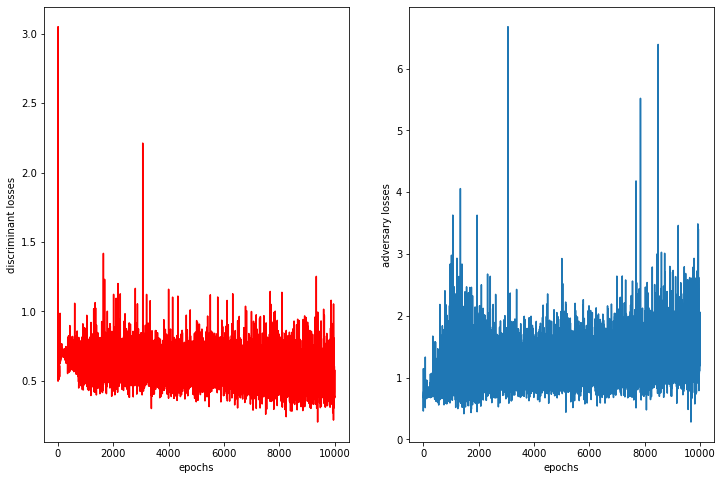

In [14]:
plt.figure(1, figsize=(12, 8))
plt.subplot(121)
plt.plot(d_losses, color='red')
plt.xlabel('epochs')
plt.ylabel('discriminant losses')
plt.subplot(122)
plt.plot(a_losses)
plt.xlabel('epochs')
plt.ylabel('adversary losses')
plt.show()

In [17]:
import imageio
import shutil
images_to_gif = []
for filename in os.listdir(RES_DIR):
    images_to_gif.append(imageio.imread(RES_DIR + '/' + filename))
imageio.mimsave('training.gif', images_to_gif)
# shutil.rmtree(RES_DIR)